#%%[markdown]

 # Neural ODE mixed with SINDy framework with mixture of experts
## Summary
 - We have a multistable dynamical systems that we want to learn
 - We only learn on a single attrator
 - Does it learn the other attractor ?
## Aproach
 - We have a baisis of neural networks
 - We have a set of coefficients: one set = one dataset
 - Hopefully we get a foundational model

In [ ]:
#%%

# %load_ext autoreload
# %autoreload 2

import jax

print("Available devices:", jax.devices())

from jax import config
# config.update("jax_debug_nans", True)

import jax.numpy as jnp

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx
import diffrax

# import matplotlib.pyplot as plt

from sinode import *

import optax
import time

Available devices: [cuda(id=0)]


In [ ]:
#%%

## Main hps ##
SEED = 2026
main_key = jax.random.PRNGKey(SEED)

gen_data = False
run_folder="runs/240515-092858/" if not gen_data else None
train = True or gen_data

## Data generation hps ##
T_horizon = 20
skip = 100


## Model hps ##
dict_size = 8
mlp_hidden_size = 32
mlp_depth = 3
threshold_val = 1e-2
threshold_every = 100    ## Threshold the coeffs every this many epochs
# renormalize_every = 100
use_bias = False
fixed_point_steps = 5


## Loss & optimizer hps ##
epsilon = 0e1  ## For contrastive loss
eta_inv, eta_cont, eta_spar = 1e-3, 1e-2, 1e-1

init_lr = 5e-5
sched_factor = 1.0

power_iter_steps = 5
spectral_scaling = 1.0 # since the spectral norm is under-estimated wia power iter


## (Proximal) Training hps ##
nb_outer_steps_max=500
inner_tol_model=1e-9
inner_tol_coeffs=1e-8
nb_inner_steps_max=20
proximal_beta=100.
patience=nb_outer_steps_max

## Other hps ##
print_every = 10

No generation. Loading data from: runs/240515-092858/
Data shapes: (9, 4, 20, 2) (9, 32, 20, 2)


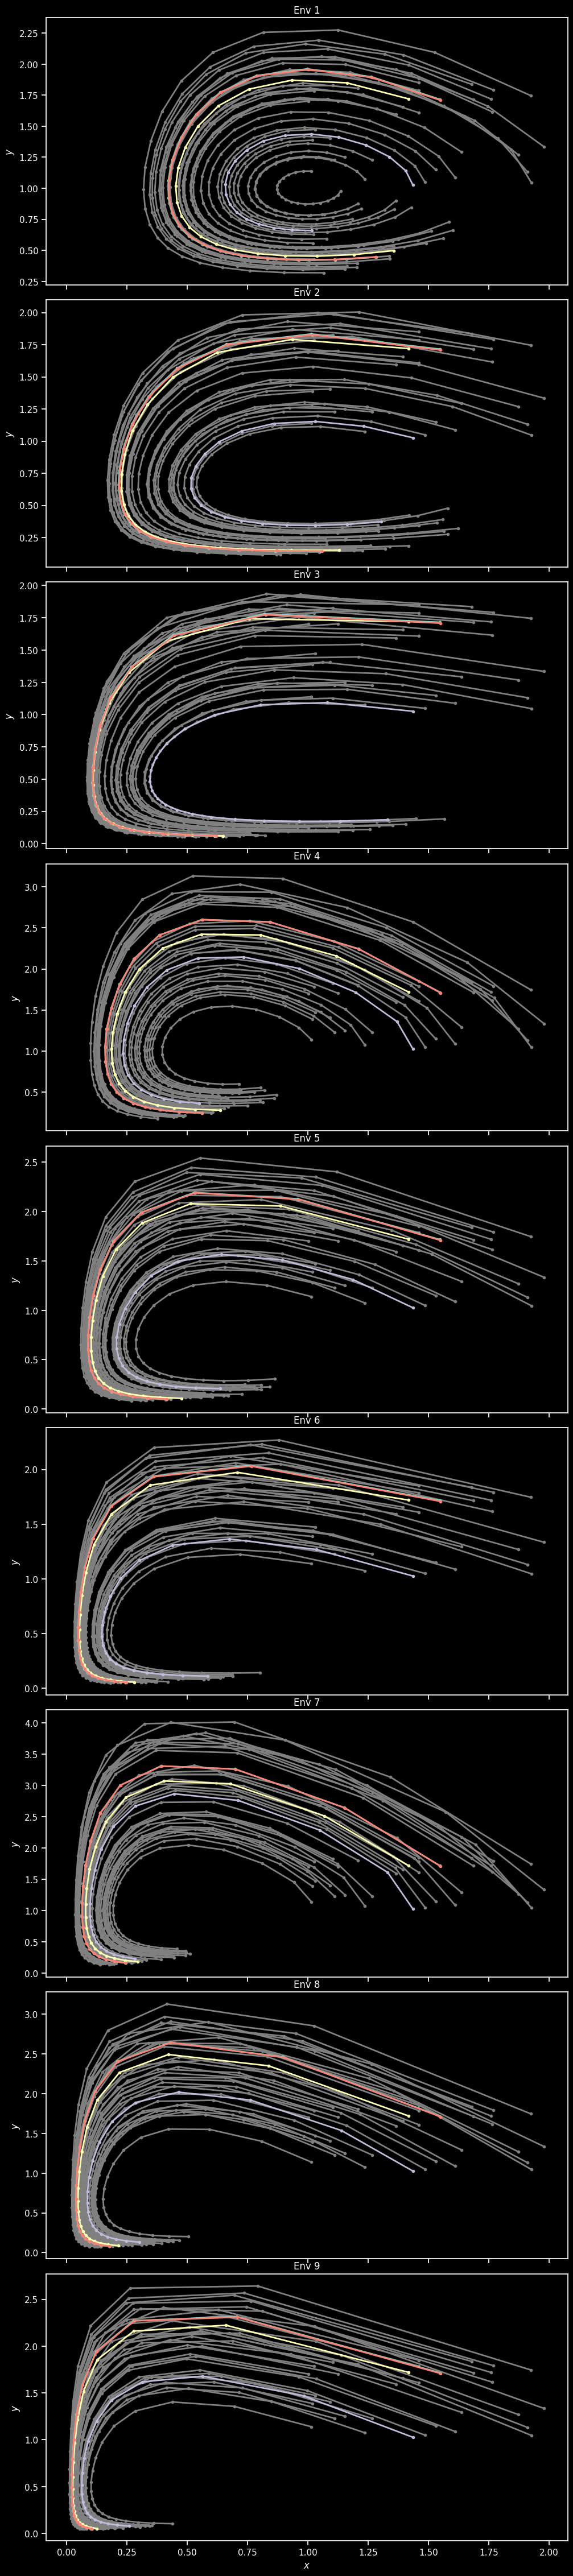

In [ ]:
#%%

t_eval, train_data = np.load(run_folder+"train_data.npz").values()
t_eval, test_data = np.load(run_folder+"test_data.npz").values()

print("No generation. Loading data from:", run_folder)

nb_envs = train_data.shape[0]
fig, axs = plt.subplots(nb_envs, 1, figsize=(10, 5*nb_envs), sharex=True)

for i in range(test_data.shape[1]):
    for e in range(nb_envs):
        sol = test_data[e, i].T
        axs[e] = sbplot(sol[0], sol[1], ".-", color="grey", ax=axs[e])

for i in range(train_data.shape[1]):
    for e in range(nb_envs):
        sol = train_data[e, i].T
        axs[e] = sbplot(sol[0], sol[1], ".-", ax=axs[e])

axs[-1].set_xlabel(r'$x$')
for e in range(nb_envs):
    axs[e].set_ylabel(r'$y$')
    axs[e].set_title(f'Env {e+1}')


print("Data shapes:", train_data.shape, test_data.shape)

In [ ]:
#%%

## Make the dataloaders
data_keys = jax.random.split(main_key)
train_dataloader = DataLoader(run_folder+"train_data.npz", batch_size=-1, shuffle=True, key=data_keys[0])
test_dataloader = DataLoader(run_folder+"test_data.npz", batch_size=-1, key=data_keys[1])

In [ ]:
# %%

class BasisFunction(eqx.Module):
    """ An MLP with a skip connection from input to output, and its inverse via fixed point iteration """
    layers: jnp.ndarray

    # transform: jnp.ndarray  ## Of size 3: scale, shift, power

    def __init__(self, in_size, out_size, hidden_size, depth, activation, key=None):
        keys = jax.random.split(key, num=depth+1)

        self.layers = []

        for i in range(depth):
            if i==0:
                layer = eqx.nn.Linear(in_size, hidden_size, use_bias=use_bias, key=keys[i])
            elif i==depth-1:
                layer = eqx.nn.Linear(hidden_size, out_size, use_bias=use_bias, key=keys[i])
            else:
                layer = eqx.nn.Linear(hidden_size, hidden_size, use_bias=use_bias, key=keys[i])

            self.layers.append(layer)

            if i != depth-1:
                self.layers.append(activation)

        # self.transform = jnp.array([1.0, 0.0, 1.0, 0.0])   ## Identity transform


    def __call__(self, x):
        """ Returns y such that y = x + MLP(x) """
        y = x
        for layer in self.layers:
            y = layer(y)
        return x + y

    def inv_call(self, x):
        """ Returns z such that x = z + MLP(z) via fixed point iteration """
        # pass
        # return x

        z = x
        for _ in range(fixed_point_steps):
            z = x - self(z)
        return z

        # a, b, a_, b_ = self.transform
        # # return (a*self(x) + b)**p
        # return a*self(a_*x + b_) + b


## Vectorise across the model
@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def evaluate_funcs_dir(model, x):
    return model(x)

@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def evaluate_funcs_inv(model, x):
    return model.inv_call(x)


class VectorField(eqx.Module):
    basis_funcs: BasisFunction

    def __init__(self, data_size, dict_size, mlp_hidden_size, mlp_depth, key=None):
        keys = jax.random.split(key, num=dict_size)

        def make_basis_func(key):
            return BasisFunction(data_size, data_size, mlp_hidden_size, mlp_depth, jax.nn.softplus, key=key)

        self.basis_funcs = eqx.filter_vmap(make_basis_func)(keys)


    def __call__(self, t, x, coeffs):
        """ Forward call of the vector field """
        lambdas, gammas = coeffs
        # assert lambdas.shape == gammas.shape == (self.dict_size, self.data_size)

        y_direct = evaluate_funcs_dir(self.basis_funcs, x)
        # y_inverse = evaluate_funcs_inv(self.basis_funcs, x)

        # return jnp.sum(y_direct*lambdas + y_inverse*gammas, axis=0)
        # return jnp.array([y_direct[0,0], y_direct[1,1]])
        return jnp.sum(y_direct*lambdas, axis=0)


class Coefficients(eqx.Module):
    lambdas: jnp.ndarray
    gammas: jnp.ndarray

    def __init__(self, data_size, dict_size, key=None):
        # self.lambdas = jax.random.uniform(key, shape=(dict_size, data_size))
        # self.gammas = jax.random.uniform(key, shape=(dict_size, data_size))

        self.lambdas = jnp.zeros((dict_size, data_size))

        # self.lambdas = self.lambdas.at[0, 0].set(1.)            ## TODO: Remove this
        # self.lambdas = self.lambdas.at[1, 1].set(1.)
        # self.lambdas = self.lambdas.at[2].set(1.)

        self.gammas = jnp.zeros((dict_size, data_size))

    def __call__(self):
        return self.lambdas, self.gammas

class NeuralODE(eqx.Module):
    data_size: int
    dict_size: int
    mlp_hidden_size: int
    mlp_depth: int

    vector_field: VectorField

    def __init__(self, data_size, dict_size, mlp_hidden_size, mlp_depth, key=None):
        self.data_size = data_size
        self.dict_size = dict_size
        self.mlp_hidden_size = mlp_hidden_size
        self.mlp_depth = mlp_depth

        self.vector_field = VectorField(data_size, dict_size, mlp_hidden_size, mlp_depth, key=key)

    def __call__(self, x0s, t_eval, coeffs):

        def integrate(y0):
            sol = diffrax.diffeqsolve(
                    diffrax.ODETerm(self.vector_field),
                    diffrax.Tsit5(),
                    args=(coeffs.lambdas, coeffs.gammas),
                    t0=t_eval[0],
                    t1=t_eval[-1],
                    dt0=1e-3,
                    y0=y0,
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=t_eval),
                    # adjoint=diffrax.RecursiveCheckpointAdjoint(),
                    max_steps=4096
                )
            return sol.ys, sol.stats["num_steps"]

            # sol = RK4(self.vector_field, 
            #           (t_eval[0], t_eval[-1]), 
            #           y0, 
            #           (coeffs.lambdas, coeffs.gammas), 
            #           t_eval=t_eval, 
            #           subdivisions=4)
            # return sol, len(t_eval)*4

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)

In [ ]:
# %%

model_keys = jax.random.split(main_key, num=3)

model = NeuralODE(data_size=2, dict_size=dict_size, mlp_hidden_size=mlp_hidden_size, mlp_depth=mlp_depth, key=model_keys[0])

coeffs = []
for e in range(nb_envs):
    coeffs.append(Coefficients(data_size=2, dict_size=dict_size, key=model_keys[e+i]))
coeffs = tuple(coeffs)

In [ ]:
# %%

def loss_rec(model, coeffs, batch, key):
    """ Reconstruction loss """
    X, t = batch
    X_hat, nb_fes = model(X[:, 0, :], t, coeffs)
    return jnp.mean((X-X_hat)**2), nb_fes

def loss_inv(model, coeffs, batch, key):
    """ Inverse loss - Assures the inverses are playing their roles """
    X, _ = batch

    @eqx.filter_vmap(in_axes=(None, 0))
    @eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
    def eval_direct_inverse(basis_func, x):
        return basis_func(basis_func.inv_call(x))
    
    X_ = eval_direct_inverse(model.vector_field.basis_funcs, X.reshape(-1, model.data_size))
    X = X.reshape(-1, model.data_size)[:, None, :]

    return jnp.mean((X-X_)**2)

def loss_cont(model, coeffs, batch, key):
    """ Contrastive loss - Makes the weights of the models different """
    X, t = batch

    ## Extract and stack the weights along the last dimension
    basis_funcs = model.vector_field.basis_funcs
    weights = [layer.weight for layer in basis_funcs.layers if isinstance(layer, eqx.nn.Linear)]

    ## Sample two weights along the first dimention
    ind = jax.random.permutation(key, model.dict_size)[:2]
    # w1, w2 = weights[ind, ...]

    tot_distance = 0.
    for d in range(len(weights)):
        w1, w2 = weights[d][ind[0], ...], weights[d][ind[1], ...]
        tot_distance += jnp.mean((w1-w2)**2)

    return epsilon - tot_distance        ## Maximise the difference between the weights up to epsilon

def loss_sparsity(model, coeffs, batch, key):
    """ Sparsity loss - Makes the coefficients sparse """
    return jnp.mean(jnp.abs(coeffs.lambdas) + jnp.abs(coeffs.gammas))



def loss_fn(model, coeffs, batch, key):

    """ The loss considers one model, and also 1 coeffs (not a tuple)! """

    rec_loss, nb_fes = loss_rec(model, coeffs, batch, key)
    inv_loss = loss_inv(model, coeffs, batch, key)
    cont_loss = loss_cont(model, coeffs, batch, key)
    spar_loss = loss_sparsity(model, coeffs, batch, key)

    weighted_loss = rec_loss + eta_inv*inv_loss + eta_cont*cont_loss + eta_spar*spar_loss
    # weighted_loss = rec_loss + eta_cont*cont_loss + eta_spar*spar_loss

    return weighted_loss, (rec_loss, inv_loss, cont_loss, spar_loss, nb_fes)
    # return weighted_loss, (rec_loss, cont_loss, cont_loss, spar_loss, nb_fes)



@eqx.filter_jit
def threshold_coeffs(coeffs, threshold_val):
    ## Jnp where every values above threshold is set to 1, else 0
    clip = lambda x: jnp.where(jnp.abs(x)>=threshold_val, x, 0.)
    return jax.tree.map(clip, coeffs)




@eqx.filter_jit
@eqx.filter_vmap(in_axes=(eqx.if_array(0), None, None))
def renormalize_model(model, nb_iters, key):
    """ Renormalize the model to have a spectral norm of 1 """

    def appply_func(x):
        if jnp.ndim(x)==2:
            spectral_norm = power_iteration(x, nb_iters, key)
            return jax.lax.cond((spectral_scaling / spectral_norm) < 1.,
                                lambda z: spectral_scaling * z / spectral_norm, 
                                lambda z: z,
                                operand=x)
        else:
            return x

    return jax.tree.map(appply_func, model)

In [ ]:
#%%

total_steps = nb_outer_steps_max
boundaries_and_scales={int(total_steps*0.25):sched_factor, int(total_steps*0.5):sched_factor, int(total_steps*0.75):sched_factor}

sched_model = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=boundaries_and_scales)
sched_coeffs = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=boundaries_and_scales)

opt_model = optax.adam(sched_model)
opt_coeffs = optax.adam(sched_coeffs)





""" Train the model using the proximal gradient descent algorithm. Algorithm 2 in https://proceedings.mlr.press/v97/li19n.html"""

train_key, _ = jax.random.split(main_key)

trainer = Trainer(model=model,
                  coeffs=coeffs,
                  loss_fn=loss_fn, 
                  optimizer_model=opt_model,
                  optimizer_coeffs=opt_coeffs,
                  )


if train == True:
    start_time = time.time()

    trainer.train_proximal(nb_outer_steps_max=nb_outer_steps_max, 
                            nb_inner_steps_max=nb_inner_steps_max, 
                            proximal_reg=proximal_beta, 
                            inner_tol_model=inner_tol_model, 
                            inner_tol_coeffs=inner_tol_coeffs,
                            print_every=print_every,
                            save_path=run_folder, 
                            train_dataloader=train_dataloader, 
                            val_dataloader=train_dataloader,    ## TODO: use test !
                            patience=patience,
                            int_prop=1.0,
                            key=train_key)

    wall_time = time.time() - start_time
    time_in_hmsecs = seconds_to_hours(wall_time)
    print("\nTotal gradient descent training time: %d hours %d mins %d secs" %time_in_hmsecs)

else:
    print("\nNo training, loading model and artifacts from "+ run_folder +" folder ...\n")

    trainer.restore_trainer(path=run_folder)



=== Beginning training with proximal alternating minimization ... ===
    Number of examples in a batch: 4
    Maximum number of steps per inner minimization: 20
    Maximum number of outer minimizations: 500
    Maximum total number of training steps: 10000

Compiling function "train_step" for neural ode ...

Compiling function "train_step" for coeffs ...
    Outer Step:     0      Loss: 1.19315910     ValIndCrit: 1.19578803
        Saving best model so far ...
        -NbInnerStepsModel:    1
        -NbInnerStepsCoeffs:    1
        -DiffModel: 4.92e-06
        -DiffCoeffs:  inf
    Outer Step:    10      Loss: 0.22987403     ValIndCrit: 0.23216189
        Saving best model so far ...
        -NbInnerStepsModel:   20
        -NbInnerStepsCoeffs:   20
        -DiffModel: 1.31e-07
        -DiffCoeffs:  1.42e-06
    Outer Step:    20      Loss: 0.21881884     ValIndCrit: 0.22154713
        Saving best model so far ...
        -NbInnerStepsModel:   20
        -NbInnerStepsCoeffs:   20

==  Begining in-domain testing ... ==
    Number of training environments: 9
    Length of the testing trajectories: 20
Test Score (In-Domain): 0.0049467

==  Begining out-of-distribution bulk visualisation ... ==
    Visualized dimensions: (0, 1)
    Final length of the training trajectories: 20
    Length of the testing trajectories: 20
Visualization finished. Figure saved in: runs/240515-092858/results_batch.png


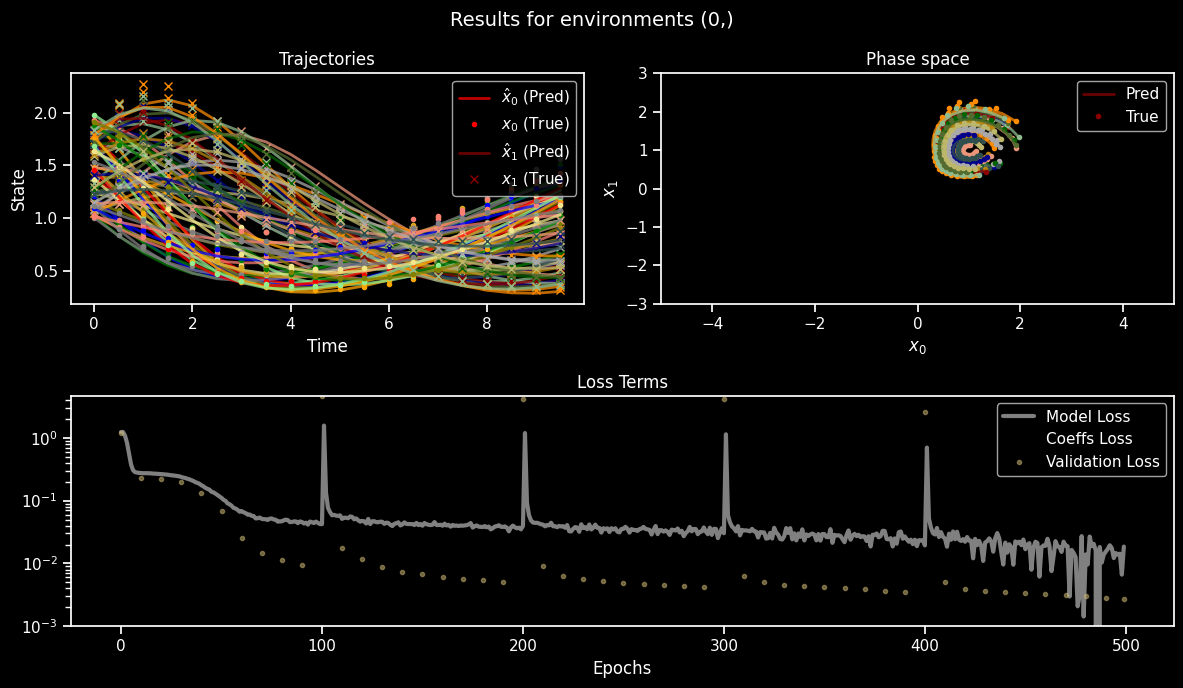

In [ ]:
# %%

visualtester = VisualTester(trainer)
vis_key = jax.random.PRNGKey(time.time_ns())

visualtester.test(test_dataloader)

# visualtester.visualize(test_dataloader, save_path=run_folder+"results.png", key=vis_key)
# visualtester.visualize(test_dataloader, save_path=run_folder+"results.png", e=0, traj=18)

visualtester.visualize_batch(test_dataloader, e_range=(0,), loss_plot_tol=1e-10, loss_plot_lim=1e-3, phase_plot_xlim=(-5,5), phase_plot_ylim=(-3,3), save_path=run_folder+"results_batch.png")

In [ ]:
# %%

## Copy nohup file to the run folder (if it exists)
if os.path.exists("nohup.log"):
    os.system(f"cp nohup.log {run_folder}nohup.log")

# %% [markdown]

 # Preliminary results
 - Nothing yet !